## Курсовой проект - предсказание цен на недвижимость

#### Импортируем библиотеки

In [5]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

#### Формируем все необходимые переменные и Dataframes

In [6]:
DATASET_PATH = r'C:\Users\Black\Desktop\курсовой проект\train.csv'
TEST_DATASET_PATH = r'C:\Users\Black\Desktop\курсовой проект\test.csv'

main_dataframe = pd.read_csv(DATASET_PATH)
final_dataframe = pd.read_csv(TEST_DATASET_PATH)

main_dataframe.set_index('Id', inplace=True)
main_dataframe_price = main_dataframe[['Price']]
main_dataframe.drop('Price', axis='columns', inplace=True)

main_dataframe['DistrictId'] = main_dataframe['DistrictId'].astype(str)
final_dataframe['DistrictId'] = final_dataframe['DistrictId'].astype(str)

preds_final = pd.DataFrame()
preds_final['Id'] = final_dataframe['Id'].copy()

#### Класс для очистки данных

In [7]:
class Cleaning(object):

    def __init__(self):
        self.medians = None
        self.DistrictHouseYearMedian = {}
        self.DistrictRoomSquareMedian = {}
        self.DistrictKitchenSquareMedian = {}
        self.year = dt.datetime.now().year

    def __district_medians(self, df):
        # Расчет медианы возраста домов в разрезе каждого района
        dist_list = df['DistrictId'].unique()
        for i in dist_list:
            self.DistrictHouseYearMedian[i] = df.loc[df['DistrictId'] == i, 'HouseYear'].median()

        # Расчет медианы площади комнат в разрезе каждого района
        for i in dist_list:
            self.DistrictRoomSquareMedian[i] = df.loc[df['DistrictId'] == i, 'Square'].median() / df.loc[
                df['DistrictId'] == i, 'Rooms'].median()

    def fit(self, df):
        self.medians = df.median()
        self.__district_medians(df)  # Заполняем словари DistrictHouseYearMedian и DistrictRoomSquareMedian

    def refactor_func(self, df):
        # Обработка поля HouseYear
        for key, value in self.DistrictHouseYearMedian.items():
            df.loc[(df['HouseYear'] > self.year) & (df['DistrictId'] == key), 'HouseYear'] = value

        #  Обработка поля Rooms
        for key, value in self.DistrictRoomSquareMedian.items():
            df.loc[(df['Rooms'] == 0) & (df['DistrictId'] == key), 'Rooms'] = round(
                df.loc[(df['Rooms'] == 0) & (df['DistrictId'] == key), 'Square'] / value
            )

        #  Обработка поля KitchenSquare
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        df.loc[df['KitchenSquare'] > 30, 'KitchenSquare'] = self.medians['KitchenSquare']

        # Обработка полей HouseFloor и Floor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']

        #  Обработка поля Healthcare
        df.drop('Healthcare_1', axis='columns', inplace=True)

        # LifeSquare
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1

        condition = (df['LifeSquare'].isna()) & (df['Square'].notna()) & (df['KitchenSquare'].notna())
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare']

        return df


#### Класс для формирования фичей

In [8]:
class FeatureGenerator(object):
    def __init__(self):
        self.binary_to_numbers = None
        self.DistrictRoomsPriceMedian = None
        self.FloorYearPriceMedian = None
        self.DistrictId_counts = None
        self.med_price_by_floor_year = None
        self.DistrictMedianCost = {}
        self.FloorCatMedPrice = {}

    def fit(self, df, price_info=None):
        self.binary_to_numbers = {'A': 0, 'B': 1}
        # DistrictID
        x_df = df.copy()
        district = x_df['DistrictId'].value_counts()
        district = district[district > 50]

        self.DistrictId_counts = dict(district)

        if price_info is not None:
            x_df['Price'] = price_info
            x_df['DistrictId_popular'] = x_df['DistrictId'].copy()
            x_df.loc[~x_df['DistrictId_popular'].isin(list(district.keys()))] = np.nan
            self.DistrictRoomsPriceMedian = x_df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({
                'Price': 'median'
            }).rename(columns={'Price': 'DistrictPriceMedian', 'DistrictId_popular': 'DistrictId'})

        if price_info is not None:
            x_df['Price'] = price_info
            x_df = self.floor_to_cat(x_df)
            x_df = self.year_to_cat(x_df)
            self.med_price_by_floor_year = x_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({
                'Price': 'median'
            }).rename(columns={'Price': 'MedPriceByFloorYear'})

        if price_info is not None:
            x_df['Price'] = price_info
            x_df['med_cost'] = x_df['Price'] / x_df['Square']
            dist_list = x_df['DistrictId'].unique()
            for i in dist_list:
                self.DistrictMedianCost[i] = x_df.loc[x_df['DistrictId'] == i, 'med_cost'].median()

    def transform(self, df):
        # Создаем фичи категориальные по полям Floor и HouseYear
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)

        # DistrictId
        df['DistrictId_count'] = df['DistrictId'].map(self.DistrictId_counts)
        df['DistrictMedianMetrCost'] = df['DistrictId'].map(self.DistrictMedianCost)
        # df['Floor_Cat_MedianCost'] = df['floor_cat'].map(self.FloorCatMedPrice)
        df['new_district'] = 0
        df.loc[df['DistrictId_count'].isna(), 'new_district'] = 1
        df['DistrictId_count'].fillna(5, inplace=True)

        df['effective_area'] = (df['LifeSquare'] + df['KitchenSquare']) / df['Square']

        # Бинарные фичи, меняем согласно словарю binary_to_numbers
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)

        # Target encoding
        if self.DistrictRoomsPriceMedian is not None:
            df = df.merge(self.DistrictRoomsPriceMedian, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            df = df.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')

        return df

    @staticmethod
    def floor_to_cat(df):

        df['floor_cat'] = np.nan

        df.loc[df['Floor'] < 3, 'floor_cat'] = 1
        df.loc[(df['Floor'] >= 3) & (df['Floor'] <= 5), 'floor_cat'] = 2
        df.loc[(df['Floor'] > 5) & (df['Floor'] <= 9), 'floor_cat'] = 3
        df.loc[(df['Floor'] > 9) & (df['Floor'] <= 15), 'floor_cat'] = 4
        df.loc[df['Floor'] > 15, 'floor_cat'] = 5

        return df

    @staticmethod
    def year_to_cat(df):

        df['year_cat'] = np.nan

        df.loc[df['HouseYear'] < 1941, 'year_cat'] = 1
        df.loc[(df['HouseYear'] >= 1941) & (df['HouseYear'] <= 1945), 'year_cat'] = 2
        df.loc[(df['HouseYear'] > 1945) & (df['HouseYear'] <= 1980), 'year_cat'] = 3
        df.loc[(df['HouseYear'] > 1980) & (df['HouseYear'] <= 2000), 'year_cat'] = 4
        df.loc[(df['HouseYear'] > 2000) & (df['HouseYear'] <= 2010), 'year_cat'] = 5
        df.loc[(df['HouseYear'] > 2010), 'year_cat'] = 6

        return df

#### Обработка/трансформация данных

In [9]:
# Часть 1
x = Cleaning()
x.fit(df=main_dataframe)
main_dataframe = x.refactor_func(main_dataframe)
final_dataframe = x.refactor_func(final_dataframe)


# Часть 2
features = FeatureGenerator()
features.fit(main_dataframe, main_dataframe_price)

main_dataframe = features.transform(main_dataframe)
final_dataframe = features.transform(final_dataframe)

#### Выбор используемых фичей

In [10]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Social_2',
                   'Social_3', 'Shops_1', 'HouseFloor_outlier', 'LifeSquare_nan', 'HouseFloor', 'HouseYear',
                   'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2', 'DistrictPriceMedian',
                   'MedPriceByFloorYear', 'Helthcare_2', 'DistrictMedianMetrCost']


main_dataframe = main_dataframe[remain_features]
final_dataframe = final_dataframe[remain_features]

#### Создание и обучение модели

In [11]:
model = LGBMRegressor(max_depth=8, n_estimators=350, random_state=42, num_leaves=11, max_bin=295)
cv_score = cross_val_score(model, main_dataframe, main_dataframe_price.values.ravel(),
                           scoring='r2',
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))

# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

# Обучаю модель
model.fit(main_dataframe, main_dataframe_price)


R2: 0.751 +- 0.018


LGBMRegressor(max_bin=295, max_depth=8, n_estimators=350, num_leaves=11,
              random_state=42)

#### Визуализация весов каждой фичи

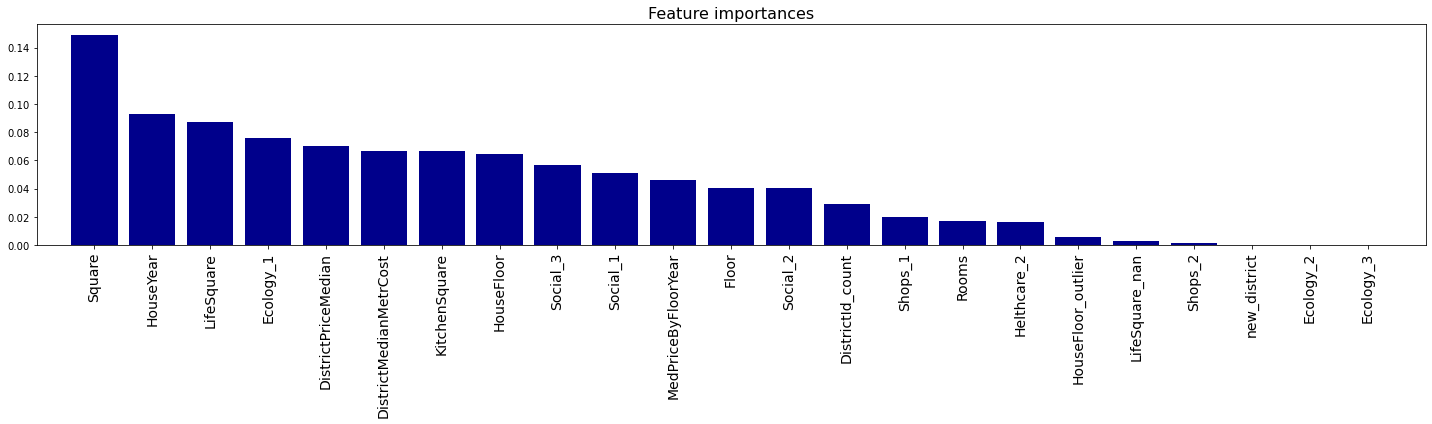

In [12]:
def plot_feature_importances(importances, X):
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
            color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.savefig('fe.jpg')
    plt.show()


plot_feature_importances(importances=model.feature_importances_, X=main_dataframe)

#### Предсказание и сохранение результата

In [13]:
pred_final = model.predict(final_dataframe)

preds_final['Price'] = pred_final
preds_final.to_csv('predictions.csv', index=False)

print(preds_final.head())
print(preds_final.shape)

      Id          Price
0    725  154101.001160
1  15856  242878.931795
2   5480  209697.439750
3  15664  308811.931771
4  14275  140510.058169
(5000, 2)
